In [2]:
import os
import io
import numpy as np
import sklearn as sk
import sklearn.model_selection
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import export_graphviz
from sklearn.metrics import accuracy_score
import pandas as pd
import collections
import matplotlib.pyplot as plt
import pydotplus
from IPython.display import clear_output
#import graphviz as g

#Model taken from https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/


In [3]:
## Import and prepare data

dfTrain = pd.read_csv('synthetic_data_mutated.csv', header=None)
dfTest = pd.read_csv('test_synthetic_data_mutated.csv', header=None)

#print(dfTrain) #Uncomment to see imported data
#print(len(dfTest.index))

In [96]:
xTrain = dfTrain[[1]]
xTrain.columns = ['sequence']
xTrain.insert(0, 'protein', 'synthetic')
yTrain = dfTrain[[0]]
yTrain.columns = ['tm']

xTest = dfTest[[1]]
xTest.columns = ['sequence']
xTest.insert(0, 'protein', 'synthetic')
yTest = dfTest[[0]]
yTest.columns = ['tm']
 
print(xTest)

      protein                                           sequence
0   synthetic  ACDYTCGSNCYSSSDVSTAQAAGYKLHEDGETVGSNSYPHKYNNYE...
1   synthetic  MFQQEVTITAPNGLHTRPAAQFVKEAKGFTSEITVTSNGKSASAKS...
2   synthetic  ERDCRVSSFRVKENFDKARFSGTWYAMAKKDPEGLFLQDNIVAEFS...
3   synthetic  TEFGSELKSFPEVVGKTVDQAREYFTLHYPQYNVYFLPEGSPVTLD...
4   synthetic  TEFKAGSAKKGATLFKTRCLQCHTVEKGGPHKVGPNLHGIFGRHSG...
5   synthetic  ATVPDLESDSFHVDWYSTYAELRETAPVTPVRFLGQDAWLVTGYDE...
6   synthetic  MERYESLFAQLKERKEGAFVPFVTLGDPGIEQSLKIIDTLIEAGAD...
7   synthetic  MVSAKDFSGAELYTLEEVQYGKFEARMKMAAASGTVSSMFLYQNGS...
8   synthetic  MNLSRRQLLALTSAGIAMGQASKLAAATKAAEQTGLKSAYKDNFLI...
9   synthetic  GLSDGEWQQVLNVWGKVEADIAGHGQEVLIRLFTGHPETLEKFDKF...
10  synthetic  MLEGKVKWFNSEKGFGFIEVEGQDDVFVHFSAIQGEGFKTLEEGQA...
11  synthetic                 XRMKQLEDKVEELLSKNYHLENEVARLKKLVGER
12  synthetic  TTETIQSNANLAPLPPHVPEHLVFDFDMYNPSNLSAGVQEAWAVLQ...
13  synthetic  VLSEGEWQLVLHVWAKVEADVAGHGQDILIRLFKSHPETLEKFDRF...
14  synthetic  MMKMEGIALK

In [5]:
POLAR_AMINO_ACIDS = ['D', 'E', 'K', 'R', 'H', 'S', 'T', 'Q', 'N', 'Y']
NON_POLAR_AMINO_ACIDS = ['A', 'V', 'L', 'I', 'M', 'F', 'W']
SPECIAL_AMINO_ACIDS = ['G', 'C', 'P']

POLAR_KEY = "polar"
NON_POLAR_KEY = "nonpolar"
SPECIAL_KEY = "special"

datasetSize = len(xTrain)
doneCount = 0
## Features taken from Ruben's NN model + baseline + others
# Add features to training data
# bigram, unigrams, trigrams, ratios of hydrophobic to hydrophilic, ratios of various amino acids to each other, cysteine location within the sequence - middle veg end
for index, row in xTrain.iterrows():
    clear_output(wait=True)
    sequence = row[1]
    counts = collections.Counter(sequence)
    # Length feature
    xTrain.at[index, 'Length'] = len(sequence)

    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        xTrain.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        xTrain.at[index, '(E + K)/(Q + H)'] = 0  
    
    for key in counts.keys():
        # Aminoacid count feature
        xTrain.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        xTrain.at[index, "presence " + key] = 1
    
    '''
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(bigrams)

    
    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        xTrain.at[index, "num " + key] = counts[key]
    #print(trigramsDict)
    '''
    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }
    
    for i in range(len(sequence)):
        if sequence[i] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[i] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[i] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        xTrain.at[index, "num " + key] = individual_counts[key]
    
    #print(individual_counts)
    #print("Protein done")
    doneCount += 1
    print("Current progress: ", np.round(doneCount/len(xTrain) * 100, 2), "%")
    
xTrain = xTrain.fillna(0)
#print(xTrain)

#Make a list of all features
featureNames = []
featureValues = {}
for feature in xTrain.columns.tolist()[2:]:
    featureNames.append(feature)
for feature in featureNames:
    featureValues[feature] = xTrain[feature]
    
#print(featureNames)
#print(featureValues['Length'].tolist()) #Uncomment to see features and values for training data

Current progress:  100.0 %


In [6]:
print(len(featureNames))
for featureName in featureNames:
    print(featureName)

47
Length
(E + K)/(Q + H)
num S
presence S
num E
presence E
num K
presence K
num I
presence I
num N
presence N
num D
presence D
num L
presence L
num R
presence R
num Q
presence Q
num G
presence G
num T
presence T
num A
presence A
num Y
presence Y
num H
presence H
num F
presence F
num W
presence W
num V
presence V
num C
presence C
num P
presence P
num M
presence M
num polar
num nonpolar
num special
num X
presence X


In [139]:
# Extract features from sequence
def extractSeqFeatures(sequence, features):
    sequenceDF = pd.DataFrame()
    counts = collections.Counter(sequence)
    # Length feature
    sequenceDF.at[index, 'Length'] = len(sequence)
    
    # add (E + K)/(Q + H) ratio feature
    if (counts['Q'] + counts['H']) != 0:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = (counts['E'] + counts['K']) /(counts['Q'] + counts['H'])
    else:
        sequenceDF.at[index, '(E + K)/(Q + H)'] = 0  
        
    for key in counts.keys():
        # Aminoacid frequency feature
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
        # Aminoacid presence feature
        if "presence " + key in featureNames:
            sequenceDF.at[index, "presence " + key] = 1
    
    
    
    #Bigrams feature
    bigramsDict = collections.defaultdict(lambda: 0)
    bigrams = [sequence[i:i+2] for i in range(len(sequence)-2+1)]
    #Populate bigrams dictionary
    for bigram in bigrams:
        bigramsDict[bigram] += 1
    #Add counts as features
    for key in bigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(bigrams)


    #Trigrams feature
    trigramsDict = collections.defaultdict(lambda: 0)
    trigrams = [sequence[i:i+3] for i in range(len(sequence)-3+1)]
    #print(trigrams)
    for trigram in trigrams:
        trigramsDict[trigram] += 1
    #Add counts as features
    for key in trigramsDict.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = counts[key]
    #print(trigramsDict)   
    
    
    #Polarity feature
    individual_counts = {
        POLAR_KEY : 0,
        NON_POLAR_KEY : 0,
        SPECIAL_KEY : 0,
    }

    for aminoacid in range(len(sequence)):
        if sequence[aminoacid] in POLAR_AMINO_ACIDS:
            individual_counts[POLAR_KEY] += 1
        elif sequence[aminoacid] in NON_POLAR_AMINO_ACIDS:
            individual_counts[NON_POLAR_KEY] += 1
        elif sequence[aminoacid] in SPECIAL_AMINO_ACIDS:
            individual_counts[SPECIAL_KEY] += 1

    for key in individual_counts.keys():
        if "num " + key in featureNames:
            sequenceDF.at[index, "num " + key] = individual_counts[key]
    
    
    # Fill out features not found
    for name in featureNames:
        if name not in sequenceDF.columns.values:
            sequenceDF.at[index, name] = 0.0
            
    sequenceDF = sequenceDF.fillna(0)
    return sequenceDF    

In [8]:
print(extractSeqFeatures('AXYSYX', featureNames))
count = 0
for colTitle in extractSeqFeatures('AXYSYX', featureNames).columns.tolist():
    print(colTitle)
    

       Length  (E + K)/(Q + H)  num A  presence A  num X  presence X  num Y  \
34632     6.0              0.0    1.0         1.0    2.0         1.0    2.0   

       presence Y  num S  presence S  ...  num W  presence W  num V  \
34632         1.0    1.0         1.0  ...    0.0         0.0    0.0   

       presence V  num C  presence C  num P  presence P  num M  presence M  
34632         0.0    0.0         0.0    0.0         0.0    0.0         0.0  

[1 rows x 47 columns]
Length
(E + K)/(Q + H)
num A
presence A
num X
presence X
num Y
presence Y
num S
presence S
num polar
num nonpolar
num special
num E
presence E
num K
presence K
num I
presence I
num N
presence N
num D
presence D
num L
presence L
num R
presence R
num Q
presence Q
num G
presence G
num T
presence T
num H
presence H
num F
presence F
num W
presence W
num V
presence V
num C
presence C
num P
presence P
num M
presence M


In [64]:
from sklearn.tree import DecisionTreeRegressor

# Create tree
rTree = DecisionTreeRegressor(criterion='mse')

# Make list of training features data
XTrainFeatures = []
for row in xTrain.iterrows():
    index, data = row
    XTrainFeatures.append(data.tolist()[2:]) # Starting from 2 so that name and sequence not in list

print(XTrainFeatures[0])

YTrainTargets = yTrain

print("Training Tree...")
# Fit tree according to features
rTree = rTree.fit(XTrainFeatures, YTrainTargets)
print("Done Training Tree.")

#print(XTrainFeatures)
prediction = rTree.predict([XTrainFeatures[8]])

# Update testing dataset
XTestFeatures = []
#print(xTest)
for row in xTest.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTestFeatures.append(featuresDF.values.tolist())
    
# Update testing dataset
XTrainFeats = []
#print(xTest)
for row in xTrain.iterrows():
    index, data = row
    sequence = data[1]
    featuresDF = extractSeqFeatures(sequence, featureNames)
    XTrainFeats.append(featuresDF.values.tolist())
    
y_Pred_Train = []
for data in XTrainFeats:
    prediction_Tm = rTree.predict(data)
    y_Pred_Train.append(prediction_Tm[0])

y_Pred_Test = []
for data in XTestFeatures:
    prediction_Tm = rTree.predict(data)
    y_Pred_Test.append(prediction_Tm[0])



[233.0, 2.1666666666666665, 12.0, 1.0, 15.0, 1.0, 24.0, 1.0, 10.0, 1.0, 19.0, 1.0, 17.0, 1.0, 23.0, 1.0, 7.0, 1.0, 12.0, 1.0, 15.0, 1.0, 17.0, 1.0, 7.0, 1.0, 18.0, 1.0, 6.0, 1.0, 8.0, 1.0, 2.0, 1.0, 13.0, 1.0, 2.0, 1.0, 4.0, 1.0, 2.0, 1.0, 147.0, 65.0, 21.0, 0.0, 0.0]
Training Tree...
Done Training Tree.


In [141]:

yTrainList = [int(i) for i in yTrain['tm']]
#print(yTrainList)
print(featureNames)
print(xTest.ix[12]['sequence'])
print(yTest.ix[12])
print(XTestFeatures[12])
print(extractSeqFeatures(xTest.ix[12]['sequence'], featureNames))
#print(yTest.ix[12])
yTrainPredList = [int(i) for i in y_Pred_Train]
yTestList =[int(i) for i in yTest['tm']]
yTestPredList = [int(i) for i in y_Pred_Test]
#print(yTrainList)
#print(yTrainPredList[13])
print(yTestList[12])
print(yTestPredList[12])
print("Train set accuracy is: ", accuracy_score(yTrainList, yTrainPredList))
print("Test set accuracy is: ",accuracy_score(yTestList, yTestPredList))



['Length', '(E + K)/(Q + H)', 'num S', 'presence S', 'num E', 'presence E', 'num K', 'presence K', 'num I', 'presence I', 'num N', 'presence N', 'num D', 'presence D', 'num L', 'presence L', 'num R', 'presence R', 'num Q', 'presence Q', 'num G', 'presence G', 'num T', 'presence T', 'num A', 'presence A', 'num Y', 'presence Y', 'num H', 'presence H', 'num F', 'presence F', 'num W', 'presence W', 'num V', 'presence V', 'num C', 'presence C', 'num P', 'presence P', 'num M', 'presence M', 'num polar', 'num nonpolar', 'num special', 'num X', 'presence X']
TTETIQSNANLAPLPPHVPEHLVFDFDMYNPSNLSAGVQEAWAVLQESNVPDLVWTRCNGGHWIATRGQLIREAYEDYRHFSSECPFIPREAGEAYDFIPTSMDPPEQRQFRALANQVVGMPVVDKLENRIQELACSLIESLRPQGQCNFTEDYAEPFPIRIFMLLAGLPEEDIPHLKYLTDQMTRPDGSMTFAEAKEALYDYLIPIIEQRRQKPGTDAISIVANGQVNGRPITSDEAKRMCGLLLVGGLDTVVNFLSFSMEFLAKSPEHRQELIERPERIPAACEELLRRFSLVADGRILTSDYEFHGVQLKKGDQILLPQMLSGLDERENACPMHVDFSRQKVSHTTFGHGSHLCLGQHLARREIIVTLKEWLTRIPDFSIAPGAQIQHKSGIVSGVQALPLVWDPATTKAV
tm    324.15
Name: 12, dtype

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


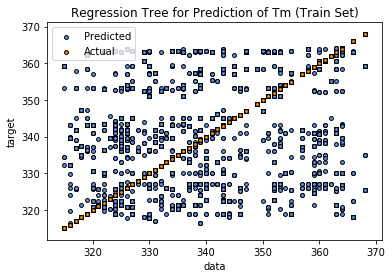

In [66]:
import random
# Plot training set results
fig = plt.figure(edgecolor='black')
#print(df['protein'].tolist())
ax1 = plt.scatter(yTrainList, y_Pred_Train, edgecolor="black",
            c="cornflowerblue", s= 15, label="Predicted")
ax2 = plt.scatter(yTrainList, yTrainList, s=15, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Train Set)")
plt.legend()
plt.show()
ax1.set_facecolor('tab:blue')
ax2.set_facecolor('tab:blue')
fig.set_facecolor('tab:blue')

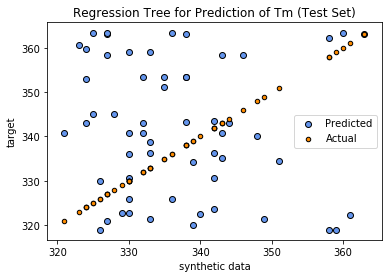

In [67]:
import random
# Plot testing set results
y = plt.figure()
#print(df['protein'].tolist())
plt.scatter(yTestList, y_Pred_Test, edgecolor="black",
            c="cornflowerblue", label="Predicted")
plt.scatter(yTestList, yTestList, s=20, edgecolor="black",
            c="darkorange", label="Actual")

#print(XTrainFeatures)
#print(y_Pred)
plt.xlabel("synthetic data")
plt.ylabel("target")
plt.title("Regression Tree for Prediction of Tm (Test Set)")
plt.legend()
plt.show()